<a href="https://colab.research.google.com/github/liangchow/zindi-amazon-secret-runway/blob/main/image_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Setup.

In [1]:
%%capture
!pip -q install rasterio
!pip -q install osmnx

In [2]:
import os
import re
#import torch
import rasterio.features
from rasterio.features import rasterize
from rasterio.enums import MergeAlg
import json
from shapely.geometry import LineString, Polygon, shape
import osmnx as ox

# Data manipulation and visualization
import matplotlib.pyplot as plt
import numpy as np
from skimage.measure import label, regionprops
from sklearn.decomposition import PCA
import pandas as pd
import geopandas as gpd
from pyproj import Transformer

# Set seed for reproducibility
SEED = 42
np.random.seed(SEED)

# Download  data to local compute node

## Mount your Google Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Compress files, copy over to compute node, and uncompress

In [4]:
# Navigate to the shared directory
#%cd /content/drive/MyDrive/Zindi-Amazon/
#!zip -r /content/predictions.zip WhateverDirectory
#!unzip /content/predictions.zip -d /content

# Description of process

Here's a method to identify clusters, fit lines to each one, and extract the endpoints and lengths. We'll start by identifying clusters, then fit lines to each, and finally calculate endpoints and filter based on length-to-width ratios.

**Step-by-Step Method:**
1.   **Identify Clusters:** We can identify clusters of connected pixels in the binary mask using connected component analysis. Each cluster corresponds to a connected component in the binary mask.
2.   **Fit a Line to Each Cluster:** For each identified cluster, fit a line using Principal Component Analysis (PCA), which will help determine the main axis of elongation for the cluster. The endpoints of the fitted line can be computed along this principal component.
3.   **Extract Lengths and Calculate Length/Width Ratios:** Once we have the principal component direction, calculate the length of the line by projecting the points onto the main axis. The width can be computed as the spread of points orthogonal to this main axis, allowing for length-to-width ratio calculations.
4.   **Reject bad clusters:** Airstrips are long and narrow. In the training set, the shortest LINESTRING was 376 meters. With a 20-meter buffer, the mininal lenght of the prediction shoud be over 400 meters. If we reject all clusters that do not intersect the bounding box, and are less than 300 meters long (30 pixels), we shoud remove almost all short road or dry river bed segments. For clusters that intersect the bounding box, we are not going to cut them based on the line segment lenght. If it looks like a problem, we'll devise a different cut.


In [5]:
def process_clusters(binary_mask, min_length=35, min_width=3, max_width=7):
    """
    Identifies and processes clusters (connected components) in the binary mask.
    """

    # Label connected components in the mask
    labeled_mask = label(binary_mask)
    clusters = regionprops(labeled_mask)
    image_height, image_width = binary_mask.shape  # Get image dimensions

    lines = []

    for cluster in clusters:
        # Check if the cluster has enough points for PCA
        if cluster.area < 2:  # At least 2 points needed for PCA
            # Handle clusters with insufficient points (e.g., skip, merge, etc.)
            print(f"Skipping cluster with {cluster.area} points - insufficient for PCA.")
            continue  # Skip this cluster

        # Extract the coordinates of the pixels in the cluster
        coords = cluster.coords

        # Perform PCA to find the main axis
        pca = PCA(n_components=2)
        pca.fit(coords)
        direction = pca.components_[0]
        variance = pca.explained_variance_

        # Compute the length of the cluster along the principal axis
        projected_coords = coords @ direction
        min_proj, max_proj = projected_coords.min(), projected_coords.max()
        length = max_proj - min_proj

        # Calculate width by projecting orthogonal to main axis
        # Using the max / min values we get a width that covers all
        # points, but could be impacted by outliers.
        # Using the standard deviation, we may be less susceptible to
        # outliers. Using 2 time the std, we cover 68% of all points. Using
        # 4 times the std would cover 95%. Something to test.
        orthogonal_direction = pca.components_[1]
        orthogonal_proj = coords @ orthogonal_direction
        width = orthogonal_proj.max() - orthogonal_proj.min()
        #width = 2.0 * np.std(orthogonal_proj)

        # Compute length-to-width ratio
        length_width_ratio = length / width if width != 0 else np.inf

        # Check if line touches the border:
        touches_border = any(
            (x == 0 or x == image_width - 1 or y == 0 or y == image_height - 1)
            for x, y in coords
        )


        # Filter based on length and border condition and width
        if (width >= min_width) and (width <= max_width) and ((length >= min_length and not touches_border) or (touches_border)):
            # Get endpoints of the line along the main axis
            endpoint1 = pca.mean_ + direction * (min_proj - pca.mean_ @ direction)
            endpoint2 = pca.mean_ + direction * (max_proj - pca.mean_ @ direction)
            lines.append({
                "length": length,
                "width": width,
                "ratio": length_width_ratio,
                "boundary": touches_border,
                "endpoints": (endpoint1, endpoint2)
            })

    return lines

In [6]:
def plot_clusters_and_lines(binary_mask, lines, roads_mask):
    fig, ax = plt.subplots(figsize=(20, 20))  # Set figure size

    # Create a combined mask where each pixel takes the max value between the two masks
    combined_mask = np.maximum(binary_mask, roads_mask)

    # Plot the combined mask with custom colormap for clarity
    cmap = plt.cm.gray
    cmap.set_over('blue')  # Use blue to represent roads (value 2)


    # Plot the combined mask with specific color ranges
    ax.imshow(combined_mask, cmap=cmap, vmin=0, vmax=2)

    # Plot the binary mask as background
    #ax.imshow(binary_mask, cmap="gray")

    for line in lines:
        (x1, y1), (x2, y2) = line["endpoints"]
        ax.plot([y1, y2], [x1, x2], 'r-')

    plt.show()


In [7]:
def load_binary_mask_from_geotiff(geotiff_path):
    """
    Loads the binary mask from a GeoTIFF file and returns it as a NumPy array.
    """
    with rasterio.open(geotiff_path) as src:
        # Read the first band (assuming the binary mask is single-band and in the first band)
        binary_mask = src.read(1)

    # Ensure mask is binary (values should be 0 or 1)
    binary_mask = (binary_mask > 0).astype(np.uint8)

    return binary_mask


In [22]:
def lines_to_geojson(lines, geotiff_path, roads, exclude_intersection = False, buffer_distance=200):
    """
    Converts lines with pixel coordinates to GeoJSON LINESTRING features
    using the GeoTIFF metadata, including the CRS.

    Args:
        lines: A list of line dictionaries, each with "endpoints" key.
        geotiff_path: Path to the GeoTIFF file.
        buffer_distance: Buffer distance in meters.

    Returns:
        A GeoJSON FeatureCollection containing the Polygon features with buffer.
    """

    with rasterio.open(geotiff_path) as src:
        transform = src.transform
        crs = src.crs

    features = []
    for line in lines:
        (x1, y1), (x2, y2) = line["endpoints"]

        # Convert pixel coordinates to geographic coordinates
        lon1, lat1 = rasterio.transform.xy(transform, x1, y1)
        lon2, lat2 = rasterio.transform.xy(transform, x2, y2)

        # Create Shapely LineString
        line_geom = LineString([(lon1, lat1), (lon2, lat2)])

        # Buffer the LineString (assuming UTM coordinates)
        polygon_geom_signal = line_geom.buffer(20)
        polygon_geom_buffer = line_geom.buffer(20+buffer_distance)

        # Check for intersections
        #intersects = intersects_any_geometry(line_geom, roads)
        intersects = polygon_intersects_any_geometry(polygon_geom_signal, roads)
        if intersects:
            print("Line intersects with roads")
            if exclude_intersection:
                continue


        # Create GeoJSON Polygon feature.
        # The order is critical: bacground first, then airstrip. We
        # later merge the two and it is critical to have airstrip
        # in second place.
        feature = {
            "type": "Feature",
            "geometry": polygon_geom_buffer.__geo_interface__,
            "properties": {
                "length": line["length"],
                "width": line["width"],
                "ratio": line["ratio"],
                "type": "buffer",
                "signal": 2
            }
        }
        features.append(feature)
        feature = {
            "type": "Feature",
            "geometry": polygon_geom_signal.__geo_interface__,
            "properties": {
                "length": line["length"],
                "width": line["width"],
                "ratio": line["ratio"],
                "type": "airstrip",
                "signal": 1
            }
        }
        features.append(feature)

    # Create GeoJSON FeatureCollection with CRS
    geojson = {
        "type": "FeatureCollection",
        "features": features,
        "crs": {
            "type": "name",
            "properties": {
                "name": crs.to_string()  # Get CRS as a string
            }
        }
    }

    return geojson


In [9]:
def create_mask_from_geojson(geojson_data, geotiff_path, output_path):
    """
    Creates a new GeoTIFF mask from GeoJSON polygons,
    using the metadata of an existing GeoTIFF.

    Args:
        geojson_data: The GeoJSON data containing the polygons.
        geotiff_path: Path to the original GeoTIFF file.
        output_path: Path to save the new GeoTIFF mask.
    """

    with rasterio.open(geotiff_path) as src:
        # Get metadata from original GeoTIFF
        meta = src.meta.copy()

        # Update data type to uint8 for binary mask
        #meta.update(dtype=rasterio.uint8, count=1, nodata=None)
        meta.update(dtype=rasterio.uint8, count=1, nodata=0)

        # Create an empty mask array
        mask = np.zeros((meta['height'], meta['width']), dtype=rasterio.uint8)

        # Rasterize GeoJSON polygons onto the mask with value 1
        #for feature in geojson_data['features']:
        #    # Burn the polygon with a value of 1
        #    # Use rasterio.features.rasterize instead of features.rasterize
        #    rasterio.features.rasterize(
        #        [(feature['geometry'], 1)],
        #        out=mask,
        #        transform=meta['transform'],
        #        all_touched=True,
        #        #default_value=1,  # Set polygon value to 1
        #        default_value=np.uint8(feature['properties']['signal']),  # Set polygon value to 1
        #        dtype=rasterio.uint8,
        #    )

        # Prepare geometries with associated 'signal' values for rasterization.
        # The value is 1 for airstrips and 2 for background in the buffer.
        shapes = [(feature['geometry'], feature['properties']['signal']) for feature in geojson_data['features']]

        # Rasterize the shapes with their respective 'signal' values
        rasterio.features.rasterize(
            shapes,
            out=mask,
            transform=meta['transform'],
            all_touched=True,
            dtype=rasterio.uint8,
            merge_alg=MergeAlg.replace  # Ensure each shape overwrites previous values
        )


        # Write the new mask to a GeoTIFF file
        with rasterio.open(output_path, 'w', **meta) as dst:
            dst.write(mask, indexes=1)


In [21]:
def create_dataframe_from_mask(mask_path, aoi_file):
    """
    Creates a Pandas DataFrame from a GeoTIFF mask file,
    extracting pixels with value 1 (airstrip) or
    2 (background).

    Args:
        mask_path: Path to the GeoTIFF mask file.
        aoi_file: Name of the AOI file (used in the DataFrame index).

    Returns:
        A Pandas DataFrame with columns 'pixel_id' and 'value'.
    """

    with rasterio.open(mask_path) as src:
        mask_data = src.read(1)  # Read the mask data as a NumPy array

    # Get indices of pixels with value 1 or 2
    row_indices, col_indices = np.where((mask_data == 1) | (mask_data == 2))

    # --- Overwrite label with 0 when mask_data is 2 ---
    labels = mask_data[row_indices, col_indices]  # Get original labels
    labels[labels == 2] = 0  # Overwrite 2 with 0

    # Create a list of pixel IDs in the specified format
    #
    # NOTICE THAT THE ZINDI TEAM FLIPPED THE COLUMN AND ROW!!!! THIS IS SO
    # WEIRD. MAKES NO SENSE TO BREAK WITH CONVENTIONS
    #
    #pixel_ids = [f'Tile{aoi_file}_{row}_{col}' for row, col in zip(row_indices, col_indices)]
    pixel_ids = [f'Tile{aoi_file}_{row}_{col}' for row, col in zip(col_indices, row_indices)]

    # Create the DataFrame
    df = pd.DataFrame({'tile_row_column': pixel_ids, 'label': labels})
    df.set_index('tile_row_column', inplace=True)

    return df

In [23]:
def create_dataframe_from_mask_all_pixels(mask_path, aoi_file, no_data_value=None):
    """
    Creates a Pandas DataFrame from a GeoTIFF mask file,
    setting 'no data' pixels to 0, pixels with value 2 to 0,
    and including all pixels in the image.

    Args:
        mask_path: Path to the GeoTIFF mask file.
        aoi_file: Name of the AOI file (used in the DataFrame index).
        no_data_value: The value representing 'no data' in the mask.

    Returns:
        A Pandas DataFrame with columns 'tile_row_column' and 'label'.
    """

    with rasterio.open(mask_path) as src:
        mask_data = src.read(1)  # Read the mask data
        height, width = mask_data.shape  # Get image dimensions

    # Create a list of all pixel IDs
    pixel_ids = [f'Tile{aoi_file}_{col}_{row}' for row in range(height) for col in range(width)]

    # Create a flattened array of the mask data
    mask_data_flat = mask_data.flatten()

    # Set 'no data' values to 0
    if no_data_value is not None:
        mask_data_flat[mask_data_flat == no_data_value] = 0

    # Set pixels with value 2 to 0
    mask_data_flat[mask_data_flat == 2] = 0

    # Create the DataFrame
    df = pd.DataFrame({'tile_row_column': pixel_ids, 'label': mask_data_flat})
    df.set_index('tile_row_column', inplace=True)

    return df

In [11]:
def export_dataframe_to_csv(df, csv_path):
    """
    Exports a Pandas DataFrame to a CSV file, appending if the file exists.

    Args:
        df: The Pandas DataFrame to export.
        csv_path: Path to the CSV file.
    """

    # Check if the file exists
    if os.path.exists(csv_path):
        # Append to the existing file without header
        df.to_csv(csv_path, mode='a', header=False, index=True)
    else:
        # Create a new file with header
        df.to_csv(csv_path, mode='w', header=True, index=True)


In [12]:
def extract_model_bands(text):
    """
    Extracts the part of the string after "lr0005".

    Args:
      text: The input string.

    Returns:
      The part of the string after "lr0005", or None if "lr0005" is not found.
    """
    match = re.search(r"lr0005_(.*)", text)
    if match:
        return match.group(1)
    else:
        return None


In [13]:
def modify_string_for_submission_file(input_string):
    """
    Removes "20" from the input string if it's in the format "aoi_20YY_MM".

    Args:
      input_string: The input string.

    Returns:
      The modified string with "20" removed, or the original string if
      it doesn't match the expected format.
    """
    return re.sub(r"aoi_20(\d\d)_(\d\d)", r"aoi_\1_\2", input_string)


In [14]:
def load_osm_roads(geotiff_path):
    # Open the GeoTIFF and read metadata
    with rasterio.open(geotiff_path) as src:
        bbox = src.bounds  # left, bottom, right, top in original CRS
        src_crs = src.crs  # original CRS
        transform = src.transform
        height, width = src.height, src.width

    # Define target CRS for OSM (EPSG:4326)
    target_crs = 'EPSG:4326'

    # Convert bounding box coordinates if required
    if src_crs != target_crs:
        transformer = Transformer.from_crs(src_crs, target_crs, always_xy=True)
        min_x, min_y = transformer.transform(bbox.left, bbox.bottom)
        max_x, max_y = transformer.transform(bbox.right, bbox.top)
    else:
        min_x, min_y, max_x, max_y = bbox.left, bbox.bottom, bbox.right, bbox.top

    # Query OSM within the bounding box
    roads = ox.geometries_from_bbox(north=max_y, south=min_y, east=max_x, west=min_x, tags={'highway': True})

    # Convert roads back to the original CRS of the GeoTIFF
    roads = roads.to_crs(src_crs)

    # Create an empty mask array
    mask = np.zeros((height, width), dtype=rasterio.uint8)

    # Rasterize the roads with a value of 2
    road_shapes = ((geom, 2) for geom in roads.geometry)
    mask = rasterize(
        road_shapes,
        out_shape=(height, width),
        transform=transform,
        fill=0,         # Background value
        dtype=rasterio.uint8,
    )


    return roads, mask

In [15]:
def find_intersecting_airstrips(geojson_data, roads):
    """
    Identifies airstrips in geojson_data that intersect with roads.

    Args:
      geojson_data: A GeoJSON-like dictionary containing features.
      roads: A geopandas GeoDataFrame containing road geometries.

    Returns:
      A list of airstrip features that intersect with roads.
    """

    # Create a GeoDataFrame from the GeoJSON features
    airstrips_gdf = gpd.GeoDataFrame.from_features([
        feature for feature in geojson_data['features']
        if feature['properties']['type'] == 'airstrip'
    ])

    # Assign CRS to airstrips_gdf if not already set
    if airstrips_gdf.crs is None:
        airstrips_gdf.set_crs(roads.crs, inplace=True)
    else:
        # Convert airstrips to the roads CRS if needed
        airstrips_gdf = airstrips_gdf.to_crs(roads.crs)

    # Perform spatial join to find intersections
    intersecting_airstrips = gpd.sjoin(
        airstrips_gdf, roads, how="inner", predicate="intersects"
    )

    # Return the intersecting airstrip features as a list of dictionaries
    return intersecting_airstrips.to_dict('records')

In [16]:
def intersects_any_geometry(linestring, geodataframe):
    """
    Checks if a LineString intersects any geometry in a GeoDataFrame.

    Args:
        linestring: A shapely.geometry.LineString object.
        geodataframe: A geopandas.GeoDataFrame containing geometries.

    Returns:
        True if the LineString intersects any geometry in the GeoDataFrame,
        False otherwise.
    """

    # Ensure both geometries have the same CRS
    #if linestring.crs is None and geodataframe.crs is not None:
    #    linestring = gpd.GeoSeries([linestring], crs=geodataframe.crs).iloc[0]
    #elif linestring.crs != geodataframe.crs:
    #    linestring = linestring.to_crs(geodataframe.crs)
    linestring = gpd.GeoSeries([linestring], crs=geodataframe.crs).iloc[0]

    # Check for intersections using any() for efficiency
    return geodataframe.geometry.intersects(linestring).any()


In [17]:
def polygon_intersects_any_geometry(polygon, geodataframe):
    """
    Checks if a Polygon intersects any geometry in a GeoDataFrame.

    Args:
        polygon: A shapely.geometry.Polygon object.
        geodataframe: A geopandas.GeoDataFrame containing geometries.

    Returns:
        True if the Polygon intersects any geometry in the GeoDataFrame,
        False otherwise.
    """

    # Create a GeoSeries from the Polygon and assign the geodataframe's CRS
    polygon = gpd.GeoSeries([polygon], crs=geodataframe.crs).iloc[0]

    # Check for intersections using any() for efficiency
    return geodataframe.geometry.intersects(polygon).any()

# Main loop

This is where we load the GeoTIFF file prediction, find the clusters,
clean the image and then produce a final prediction. Notice that the final prediction must have a 200 meter buffer.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-14-e99605ac2913>:21: FutureWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in the v2.0.0 release. See the OSMnx v2 migration guide: https://github.com/gboeing/osmnx/issues/1123
  roads = ox.geometries_from_bbox(north=max_y, south=min_y, east=max_x, west=min_x, tags={'highway': True})
/usr/local/lib/python3.10/dist-packages/osmnx/geometries.py:48: FutureWarning: The `north`, `south`, `east`, and `west` parameters are deprecated and will b

Processing aoi_2020_01


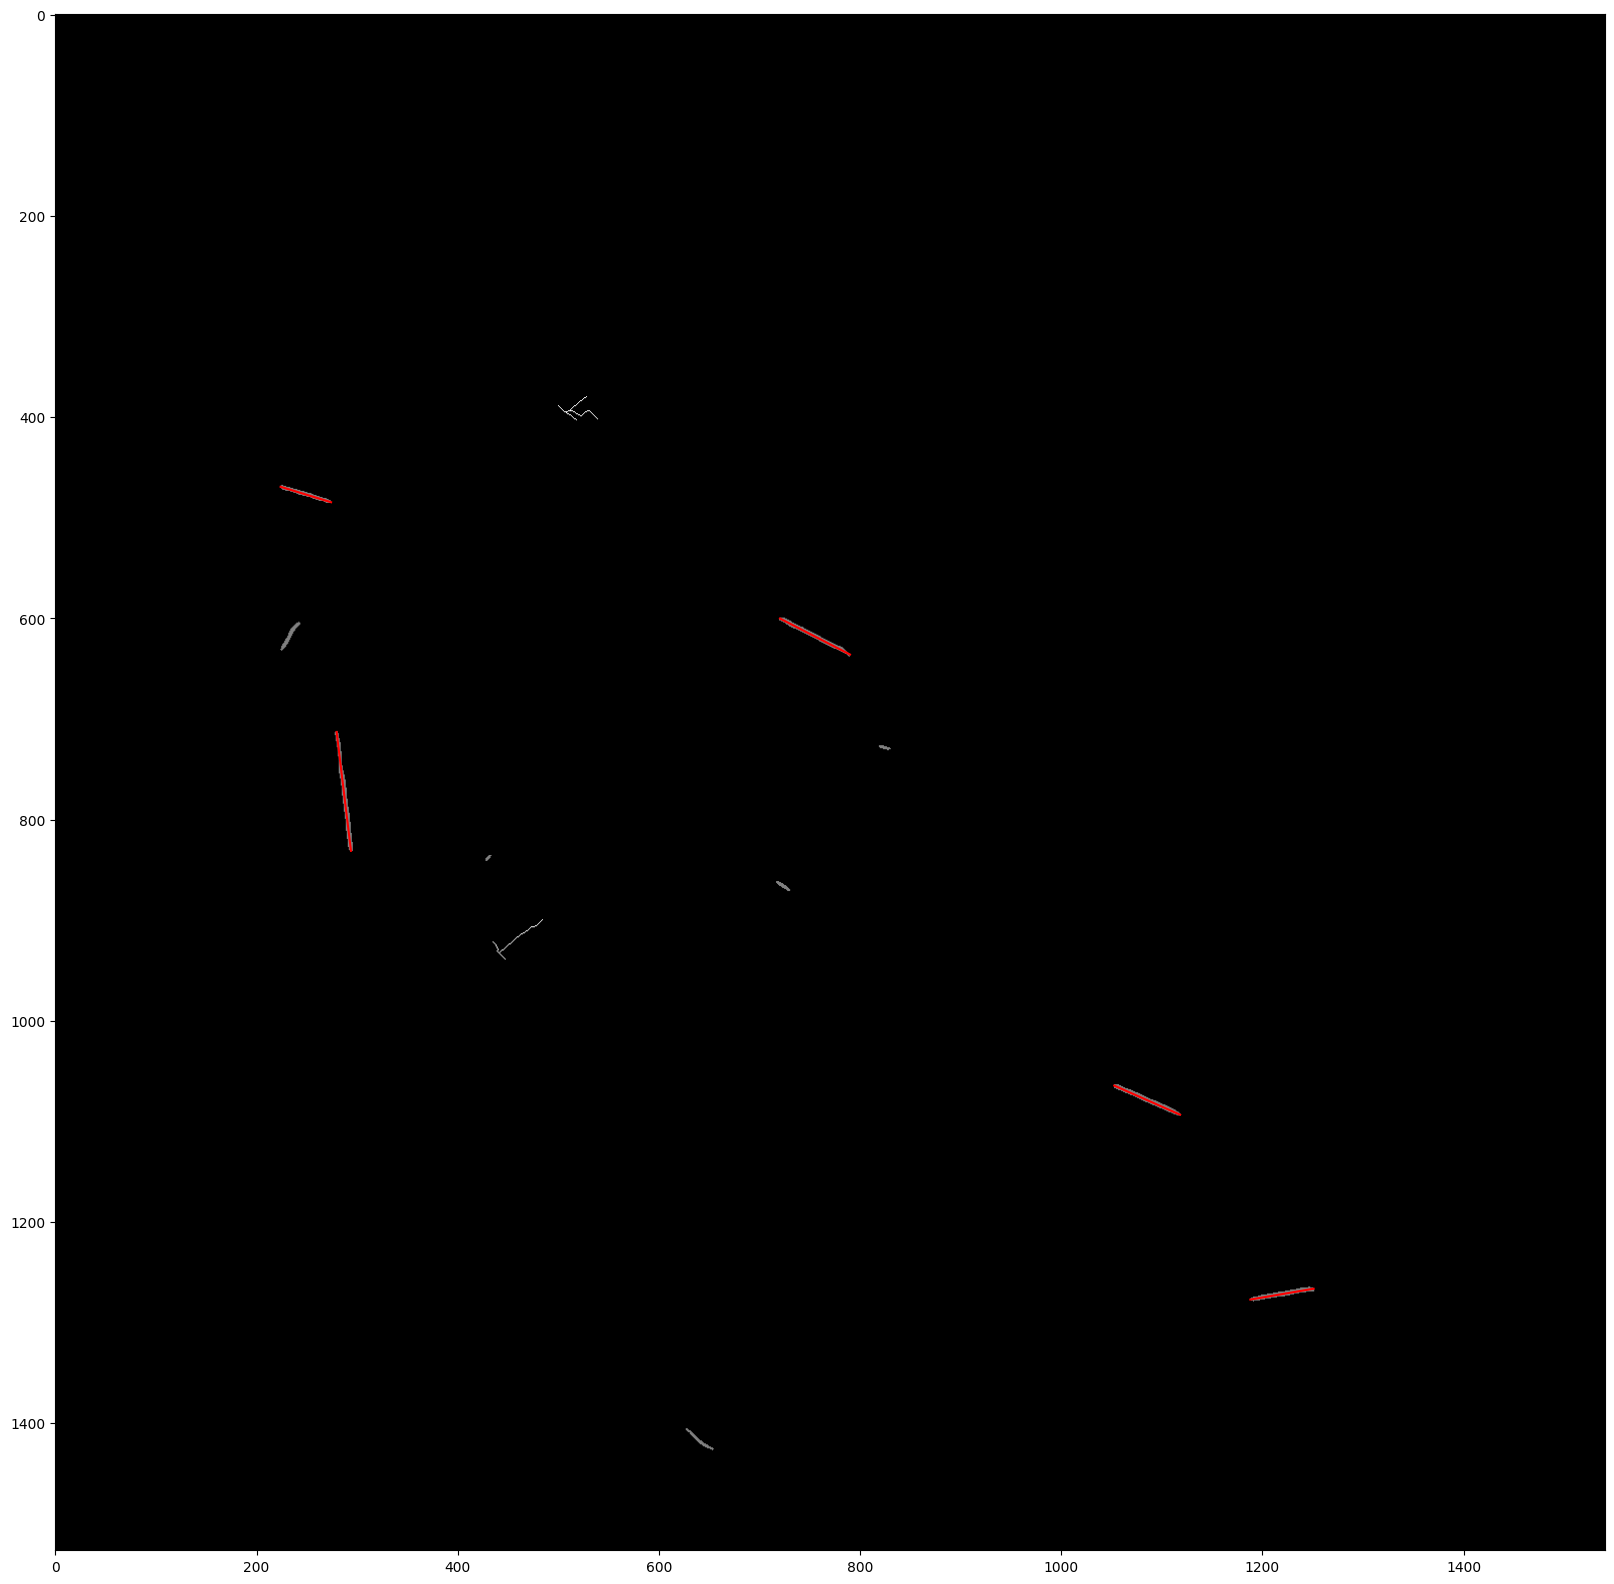

Total number of airstrips: 5


In [24]:
aoi_files = ['aoi_2020_01', 'aoi_2020_02', 'aoi_2020_03', 'aoi_2021_01', 'aoi_2021_02', 'aoi_2021_03', 'aoi_2021_04', 'aoi_2022_01', 'aoi_2022_02', 'aoi_2023_01', 'aoi_2024_01']
aoi_directory = '/content/drive/MyDrive/Zindi-Amazon/Studies/model_20241030_20m_lr0005_B4_B3_B2_B8_VV'

total_airstrips = 0
total_intersecting_airstrips = 0

full_CSV_output = False

for aoi_file in aoi_files:
    print(f'Processing {aoi_file}')
    geotiff_path = f'{aoi_directory}/{aoi_file}_prediction_mosaic.tif'

    binary_mask = load_binary_mask_from_geotiff(geotiff_path)
    lines = process_clusters(binary_mask)
    roads, roads_mask = load_osm_roads(geotiff_path)
    #print(roads.geometry.iloc[0])

    plot_clusters_and_lines(binary_mask, lines, roads_mask)

    # Output the line information
    #for line in lines:
    #    print(f" Length: {line['length']}, Width: {line['width']}, Ratio: {line['ratio']}")
    #    print(f" Endpoints: {line['endpoints']}")

    # Convert lines to GeoJSON object. This is also where we exclude lines
    # that intersect with roads.
    geojson_data = lines_to_geojson(lines, geotiff_path, roads, exclude_intersection = True)

    airstrips = [feature for feature in geojson_data['features'] if feature['properties']['type'] == 'airstrip']
    #print(f"Number of airstrips: {len(airstrips)}")
    total_airstrips += len(airstrips)

    # Print the number of intersecting airstrips
    #intersecting_airstrips = find_intersecting_airstrips(geojson_data, roads)
    #print(f"Number of intersecting airstrips: {len(intersecting_airstrips)}")
    #total_intersecting_airstrips += len(intersecting_airstrips)


    # Get model bands stored in name of the directory
    bands = extract_model_bands(aoi_directory)

    # Create final mask with padding.
    create_mask_from_geojson(geojson_data, geotiff_path, f'{aoi_file}_{bands}_prediction_final.tif')

    submission_tag = modify_string_for_submission_file(aoi_file)
    if full_CSV_output:
        df = create_dataframe_from_mask_all_pixels(f'{aoi_file}_{bands}_prediction_final.tif', submission_tag)
    else:
        df = create_dataframe_from_mask(f'{aoi_file}_{bands}_prediction_final.tif', submission_tag)

    csv_path = f'output_file_{bands}.csv'  # Path to your CSV file
    export_dataframe_to_csv(df, csv_path)
    #print(f'Number of pixels with background or signal:{len(df)}')

    #break


print(f'Total number of airstrips: {total_airstrips}')
#print(f'Total number of intersecting airstrips: {total_intersecting_airstrips}')
